In [9]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt


# Exercise 4

In [10]:
data = pd.read_excel('CCAPM_data.xls')

data['Growth consumption lag 1'] = data['Growth consumption'].shift(1)
data = data.dropna()

print(data)

     Year  Excess return  Growth consumption  Growth consumption lag 1
1    1891       0.128416            1.050310                  0.971878
2    1892       0.023361            1.018900                  1.050310
3    1893      -0.268416            1.006372                  1.018900
4    1894      -0.000383            0.955793                  1.006372
5    1895       0.018271            1.095734                  0.955793
..    ...            ...                 ...                       ...
115  2005      -0.004077            1.024169                  1.025331
116  2006       0.063077            1.019273                  1.024169
117  2007      -0.032954            1.016571                  1.019273
118  2008      -0.404143            0.988385                  1.016571
119  2009       0.242556            0.981146                  0.988385

[119 rows x 4 columns]


## 1) One equation


In [11]:
def myfun(gamma, excess_return, growth_consumption):
    # Sample moments
    G = np.mean(growth_consumption ** (-gamma) * excess_return)
    # GMM objective function (identity weighting matrix)
    GMM = G**2
    return GMM.item()

Estimate the parameter $\gamma$

In [130]:
# Starting values for the parameters
startvalues = 30

# Run the optimizer (minimize the GMM objective)
result = minimize(
    fun=myfun,
    x0=startvalues,
    args=(data['Excess return'], data['Growth consumption'],))

gamma = result.x      # Estimated parameters

In [131]:
print(gamma)

[50.22007242]


Plot the GMM objective function

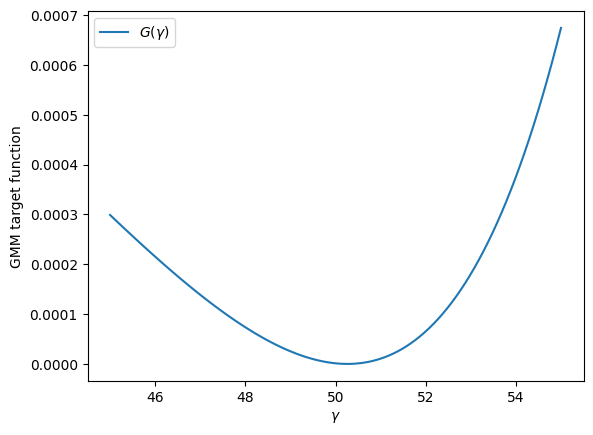

In [14]:
gamma_grid = np.linspace(45, 55, 100)
gmm_func = [myfun(gamma, data['Excess return'], data['Growth consumption']) for gamma in gamma_grid]

plt.plot(gamma_grid, gmm_func, label=r'$G(\gamma)$')

plt.xlabel(r'$\gamma$')
plt.ylabel('GMM target function')
plt.legend()
plt.show()

## b) Two equations


In [149]:
class GMMEstimator:
    def __init__(self, excess_return, growth_consumption, growth_consumption_lag, start_values):
        self.excess_return = excess_return
        self.growth_consumption = growth_consumption
        self.growth_consumption_lag = growth_consumption_lag
        if len(excess_return) == len(growth_consumption) == len(growth_consumption_lag):
            self.N = len(excess_return)
        else:
            raise ValueError("excess_return and growth_consumption must have the same length.")
            
        self.start_values = start_values
        self.g = None  # Initialize g as None
        self.W = np.eye(2)  # Initial weighting matrix: identity

    def myfun(self, theta, W):
        # Compute the individual moment conditions for each observation
        self.g = np.column_stack([
            self.growth_consumption ** (-theta[0]) * self.excess_return,
            theta[1] *  self.growth_consumption -1
        ])
        
        # Compute the sample moments (mean of g)
        G = np.mean(self.g, axis=0).reshape(-1, 1)

        # Compute the GMM objective function with the weighting matrix
        GMM = G.T @ W @ G
        return GMM.item()  # Return the scalar value

    def first_stage_estimation(self):
        # Perform the first-stage GMM estimation
        result_1 = minimize(
            fun=self.myfun,
            x0=self.start_values,
            args=(self.W,),
            method='BFGS',
            options={'disp': True}
        )
        thetaHAT_1 = result_1.x
        GMMvalue_1 = result_1.fun

        print("\nFirst-stage estimates:")
        print("thetaHAT =", thetaHAT_1)
        print("GMMvalue =", GMMvalue_1)
        print("\n")
        return thetaHAT_1

    def second_stage_estimation(self):
        # Compute the optimal weighting matrix
        self.W = np.linalg.inv((self.g.T @ self.g) / self.N)

        # Perform the second-stage GMM estimation
        result_2 = minimize(
            fun=self.myfun,
            x0=self.start_values,
            args=(self.W,),
            method='BFGS',
            options={'disp': True}
        )
        thetaHAT_2 = result_2.x
        GMMvalue_2 = result_2.fun

        print("\nSecond-stage estimates:")
        print("thetaHAT =", thetaHAT_2)
        print("GMMvalue =", GMMvalue_2)
        print("\n")

        return thetaHAT_2


Estimate $\gamma$ and $\beta$ using the 2 Stage GMM (with optimal weighting matrix)

In [150]:
# Starting values for the parameters
startvalues = [50.0, 1.0]

# Create GMM estimator object
gmm_estimator = GMMEstimator(data['Excess return'], data['Growth consumption'], data['Growth consumption lag 1'], startvalues)

# First-stage estimation
thetaHAT_1 = gmm_estimator.first_stage_estimation()

# Second-stage estimation
thetaHAT_2 = gmm_estimator.second_stage_estimation();

Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 1
         Function evaluations: 9
         Gradient evaluations: 3

First-stage estimates:
thetaHAT = [50.0000044   0.98176493]
GMMvalue = 1.2185363212394524e-06


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 1
         Function evaluations: 9
         Gradient evaluations: 3

Second-stage estimates:
thetaHAT = [49.99999991  0.98176622]
GMMvalue = 3.8055705273080035e-07




In [151]:
optimal_weights = gmm_estimator.W

gamma_range = np.linspace(45, 55, 100)
beta_range = np.linspace(0.95, 1.05, 100)

# Create the meshgrid
gamma_grid, beta_grid = np.meshgrid(gamma_range, beta_range)

# Compute the GMM objective function
gmm_values = np.vectorize(lambda gamma, beta: gmm_estimator.myfun(np.array([gamma, beta]), optimal_weights))(gamma_grid, beta_grid)


Plot the GMM objective function, using the optimal weights

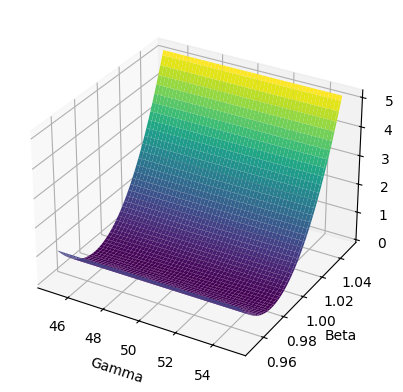

In [152]:
%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(gamma_grid, beta_grid, gmm_values, cmap='viridis', edgecolor='none')

ax.set_xlabel('Gamma')
ax.set_ylabel('Beta')
ax.set_zlabel('GMM Function Value')

plt.show()

For displaying purposes, use the following weights:
$$W= \begin{bmatrix} 10 & 0 \\ 0 & 1 \end{bmatrix}$$

In [153]:
display_weights = np.array([[10.0, 0.0], [0.0, 1.0]])
gmm_values = np.vectorize(lambda gamma, beta: gmm_estimator.myfun(np.array([gamma, beta]), display_weights))(gamma_grid, beta_grid)


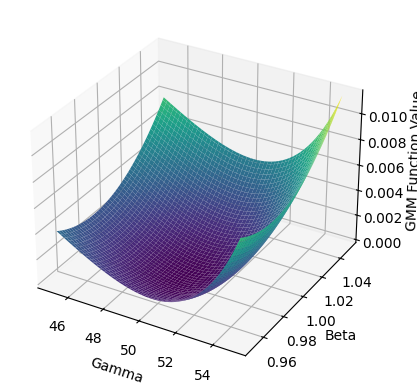

In [154]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(gamma_grid, beta_grid, gmm_values, cmap='viridis', edgecolor='none')

ax.set_xlabel('Gamma')
ax.set_ylabel('Beta')
ax.set_zlabel('GMM Function Value')

plt.show()